<a href="https://colab.research.google.com/github/alickd/SEP740_DLProject/blob/main/Text_Summarization_Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Summarizer

In [ ]:
!pip install transformers
!pip install sumy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re
import string
from keras.preprocessing.text import Tokenizer 
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import gensim
from gensim.parsing.preprocessing import remove_stopwords

from tensorflow import keras
from keras.utils.data_utils import pad_sequences
import keras_preprocessing
from keras.preprocessing import text,sequence
from keras_preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from keras.layers import Input,Dense,Embedding,LSTM,Dropout, RepeatVector, concatenate

In [ ]:
#Import and read dataset
path  = "/content/drive/MyDrive/Deep Learning Project/Reviews.xlsx"
df_reviews = pd.read_csv(path,nrows=100)
df_reviews.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'],inplace=True,axis=1)
df_reviews.dropna(axis=0,inplace=True)
df_reviews.head(5)

LSA Machine Learning Model Summary

In [ ]:
# Import the summarizer 
import sumy
from sumy.summarizers.lsa import LsaSummarizer 

# Text to summarize 
original_text = df_reviews.Text[67] 

# Parsing the text string using PlaintextParser 
from sumy.nlp.tokenizers import Tokenizer 
from sumy.parsers.plaintext import PlaintextParser 

parser=PlaintextParser.from_string(original_text,Tokenizer('english')) 

# Creating the summarizer 
lsa_summarizer=LsaSummarizer() 
lsa_summary= lsa_summarizer(parser.document,3) 

# Printing the summary 
print(original_text)
print("---------------------------------------------------------------------")
print("Summary")
for sentence in lsa_summary: 
    print(sentence) 

Pre-Processing Text Data

In [ ]:
print("Before Pre-Processing")
for i in range(3):
  print("Review ", i+1)
  print(df_reviews['Text'][i])

In [79]:
def clean_text(text):
  #Removing numbers
  text = re.sub('[^a-zA-Z]', ' ', text)
  #Convert text into lower case
  text = text.lower()
  #Remove URL links
  text = re.sub(r'http\S+',' ',text)
  #Removing extra spaces/lines
  text = re.sub(' +',' ',text)
  #Removing punctuation
  text = re.sub('[^\w\s]','',text)
  #Removing stopwords
  text = remove_stopwords(text)
  return text

In [80]:
#Pre-Processing Text Data
df_reviews["Summary"] = df_reviews["Summary"].apply(clean_text)
df_reviews["Text"] = df_reviews["Text"].apply(clean_text)

In [ ]:
print("After Pre-Processing")
for i in range(3):
  print("Review ", i+1)
  print(df_reviews['Text'][i])

Visualize the Data

In [ ]:
import itertools
import collections

lemmatized_tokens = list(df_reviews["Summary"])
token_list = list(itertools.chain(lemmatized_tokens))

counts_no=collections.Counter(token_list)
clean_words = pd.DataFrame(counts_no.most_common(30),columns=['text','count'])
fig,ax = plt.subplots(figsize=(8,8))
clean_words.sort_values(by='count').plot.barh(x='text',y='count',ax=ax,color='green')
ax.set_title("Frequency of Words")
plt.show()

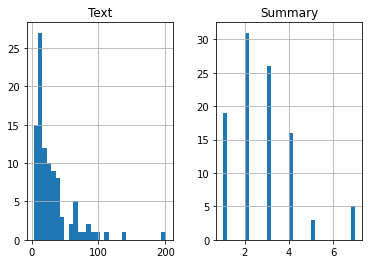

In [84]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df_reviews['Text']:
      text_word_count.append(len(i.split()))

for i in df_reviews['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text':text_word_count, 'Summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [158]:
#X_text = df_reviews['Text'].values
#y_summary = df_reviews['Summary'].values
reviews = df_reviews['Text'].values
labels = df_reviews['Summary'].values

train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=.3)
#X_train,Y_train,X_test,Y_test=train_test_split(X_text,y_summary,test_size=0.2)

In [159]:
def tokenize_dataset(X_text):
    encoded = tokenizer(
        X_text,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

# Need to convert to List[str] because the tokenizer expects List but not np.array
tokenized_datasets = {
    "train": tokenize_dataset(train_reviews.tolist()),
    "validation": tokenize_dataset(val_reviews.tolist()),
}

Hugging Face Transformers - Pretrained Model

In [ ]:
import transformers
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
from transformers import Trainer, TrainingArguments

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
#model = TFAutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [149]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    tokenized_datasets['train'],
    train_labels, 
    validation_data=(tokenized_datasets['validation'], val_labels),
    batch_size=8,
    epochs=3
)

In [143]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train, truncation = True, padding = True)
test_encodings = tokenizer(X_test, truncation = True, padding = True)

In [116]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    Y_train
))

In [115]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    Y_test
))

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer = "facebook/bart-large-cnn")

In [ ]:
sum_generated = summarizer(df_reviews['Text'][67])

In [ ]:
input_ids = tokenizer.encode("summarize:" + df_reviews["Text"][1], return_tensors='tf',truncation=True, max_length=60)
greedy_output = model.generate(input_ids,num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=30,
                                    max_length=100,
                                    early_stopping=True)
tokenizer.decode(greedy_output[0], skip_special_tokens=True)

In [ ]:
df_reviews["Text"][1]

In [129]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
model.fit(train_dataset,epochs=3,verbose=2,validation_data=test_dataset)

In [ ]:
#Tokenization
max_vocab = 1000
max_length = 200

token = Tokenizer(num_words=max_vocab)
token.fit_on_texts(X_train)
token.fit_on_texts(Y_train)

#Tokenize Train
x_train_token = token.texts_to_sequences(X_train)
x_train = pad_sequences(x_train_token, maxlen = max_length)

y_train_token = token.texts_to_sequences(Y_train)
y_train = pad_sequences(y_train_token, maxlen = max_length)

#Tokenize Test
x_test_token = token.texts_to_sequences(X_test)
x_test = pad_sequences(x_test_token, maxlen = max_length)

y_test_token = token.texts_to_sequences(Y_test)
y_test = pad_sequences(y_train_token, maxlen = max_length)

print(X_train) #text data
print(x_train) #text data in tokens
print(y_train)

In [ ]:
df_reviews['Text'][2]

In [ ]:
df_reviews['Summary'][2]

In [ ]:
print (summarizer(X_train[2]))

In [ ]:
#for i in range(5):
print (summarizer(X_test))

In [ ]:
df_reviews["Text"][6]

In [ ]:
df_reviews["Summary"][6]

In [87]:
vocab_size = 100
src_txt_length = 1000
sum_txt_length = 100
# article input model
inputs1 = Input(shape=(src_txt_length,))
article1 = Embedding(vocab_size, 128)(inputs1)
article2 = LSTM(128)(article1)
article3 = RepeatVector(sum_txt_length)(article2)
# summary input model
inputs2 = Input(shape=(sum_txt_length,))
summ1 = Embedding(vocab_size, 128)(inputs2)
# decoder model
decoder1 = concatenate([article3, summ1])
decoder2 = LSTM(128)(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# tie it together [article, summary] [word]
DL_Model = Model(inputs=[inputs1, inputs2], outputs=outputs)
DL_Model.compile(loss='categorical_crossentropy', optimizer='adam')


In [131]:
DL_Model.fit(x_train,y_train,verbose=2)

ValueError: ignored

In [ ]:
def define_models(n_input, n_output, n_units):
# define training encoder
  encoder_inputs = Input(shape=(None, n_input))
  encoder = LSTM(n_units, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  encoder_states = [state_h, state_c]
# define training decoder
  decoder_inputs = Input(shape=(None, n_output))
  decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_dense = Dense(n_output, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# define inference encoder
  encoder_model = Model(encoder_inputs, encoder_states)
# define inference decoder
  decoder_state_input_h = Input(shape=(n_units,))
  decoder_state_input_c = Input(shape=(n_units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,  initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
# return all models
  return model, encoder_model, decoder_model

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Training the Model

In [ ]:
model.fit